In [1]:
import pandas as pd
from umap import UMAP
from ivis import Ivis
import numpy as np
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
from hdbscan import HDBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas(desc="progess: ")

In [2]:
def sample_data(df, fraction, contamination, seed):
    X_n = int(df[df.outlier_label == 1].shape[0] * fraction)
    y_n = int(X_n * contamination)

    df = df.iloc[np.random.RandomState(seed=seed).permutation(len(df))]
    df = df[df["outlier_label"] == 1].head(X_n).append(
        df[df["outlier_label"] == -1].head(y_n))
    df = df.reset_index(drop=True)
    return df

def reject_outliers(sr, iq_range=0.5):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = np.quantile(sr, [pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return ((np.abs(sr - median)) >= iqr/2)

In [3]:
umap_2d = UMAP(metric="cosine", set_op_mix_ratio=1.0,
               n_components=2, random_state=42)

In [4]:
# parameters
data_path = "/home/philipp/projects/dad4td/data/processed/20_news_imdb.pkl"
#doc2vec_model_path = "/home/philipp/projects/dad4td/models/enwiki_dbow/doc2vec.bin"
#doc2vec_model = Doc2Vec.load(doc2vec_model_path)

# get test data
df = pd.read_pickle(data_path)
df = df.where(df.text.map(len) > 5)
df = sample_data(df, fraction=1.0, contamination=0.1, seed=1)

# vectorize
df

text  target  \
0      I have a 5 minute rule (sometimes I'll leave l...    -1.0   
1      This comes close to the worst movie I've ever ...    -1.0   
2      "Go Fish" garnered Rose Troche rightly or wron...    -1.0   
3      A group of friends receive word from a pal who...    -1.0   
4      96 minutes of this is cruel..and I love the ol...    -1.0   
...                                                  ...     ...   
54995  \nAs I'm sure others will have pointed out to ...    16.0   
54996  \nI am not an expert in the cryptography scien...    11.0   
54997  JB>  \nJB>    Ron Roth recommends: "Once you h...    13.0   
54998  \n\nDo you have a terminal cold? Karabag is 'T...    17.0   
54999  \n\n\nLikewise for me please. First time I've ...     1.0   

                       title  outlier_label  
0                       imdb            1.0  
1                       imdb            1.0  
2                       imdb            1.0  
3                       imdb            1.0  
4                       imdb            1.0  
...                      ...            ...  
54995     talk.politics.guns           -1.0  
54996              sci.crypt           -1.0  
54997                sci.med           -1.0  
54998  talk.politics.mideast           -1.0  
54999          comp.graphics           -1.0  

[55000 rows x 4 columns]

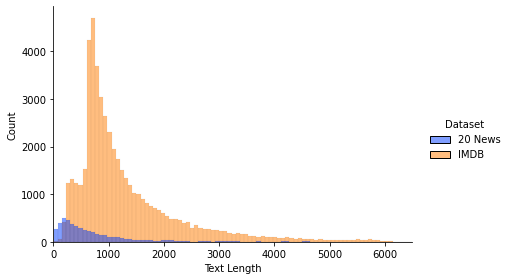

In [7]:
df["Text Length"] = df.text.map(lambda x: len(str(x)))
df["Dataset"] = df.outlier_label.map(lambda x: {1.0:"IMDB", -1.0: "20 News"}[x])
hue_order = ['20 News', 'IMDB']
g = sns.displot(data=df,x="Text Length", hue="Dataset", palette="bright", height=4, aspect=1.5, bins=1000, hue_order=hue_order)
g.set(xlim=(0, 6500))
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/imdb-20news-length-dist.png", format="png")

In [5]:
df.title.value_counts()

imdb                        50000
comp.graphics                 277
rec.sport.baseball            276
misc.forsale                  275
rec.motorcycles               274
sci.crypt                     267
sci.electronics               266
soc.religion.christian        260
sci.med                       259
sci.space                     257
comp.sys.ibm.pc.hardware      257
rec.autos                     255
rec.sport.hockey              254
comp.sys.mac.hardware         252
comp.os.ms-windows.misc       251
talk.politics.mideast         244
comp.windows.x                244
talk.politics.guns            236
alt.atheism                   225
talk.politics.misc            205
talk.religion.misc            166
Name: title, dtype: int64

In [6]:
dim_reducer = UMAP(metric="cosine", set_op_mix_ratio=1.0,
               n_components=256, random_state=42)

In [7]:
# ivis
ivis_reducer = Ivis(embedding_dims=1, k=5, n_epochs_without_progress=5, model="maaten", distance="pn")

In [8]:
# get doc2vec vectors
X = df.text
X = X.progress_apply(lambda x: simple_preprocess(x))
docvecs = X.progress_apply(lambda x: doc2vec_model.infer_vector(x))
docvecs = list(docvecs)
docvecs

progess: 100%|██████████| 55000/55000 [04:37<00:00, 198.14it/s]


[array([-2.30863154e-01,  1.52053222e-01, -1.14355840e-01,  7.98557773e-02,
        -4.31285836e-02, -1.77311957e-01,  1.90655410e-01,  1.83323383e-01,
        -3.21967810e-01,  8.53888392e-02, -5.28865047e-02, -8.88107494e-02,
        -3.62029135e-01,  3.18993405e-02,  1.93597153e-02,  3.47248822e-01,
        -5.04230618e-01,  1.64130896e-01, -1.98319629e-01, -8.82169455e-02,
         4.89515923e-02, -9.62068811e-02,  3.10769062e-02, -5.68625033e-01,
         1.75732262e-02, -1.64615571e-01, -2.41933577e-02,  4.67608348e-02,
        -3.52621078e-02, -4.18652892e-01,  1.78270325e-01,  3.40858042e-01,
        -2.15241760e-01,  3.99090886e-01,  2.89213866e-01, -6.96223438e-01,
         1.18552268e-01,  2.19523817e-01,  3.40499014e-01, -4.70133543e-01,
         3.04267108e-02,  2.96000123e-01,  3.63431245e-01, -3.57747138e-01,
         1.21477090e-01,  2.10381076e-01, -5.52884117e-02, -7.64511079e-02,
         3.14531952e-01, -1.10434376e-01, -2.00793356e-01, -3.20691243e-02,
         1.4

In [9]:
# UMAP reduction
dim_reduced_vecs = dim_reducer.fit_transform(docvecs)

In [10]:
scores = ivis_reducer.fit_transform(dim_reduced_vecs)

  5%|▌         | 2951/55000 [00:00<00:01, 29507.14it/s]

Building KNN index


100%|██████████| 55000/55000 [00:01<00:00, 31312.57it/s]


Extracting KNN from index


100%|█████████▉| 54879/55000 [00:08<00:00, 6634.58it/s] 


Training neural network
Epoch 1/1000
430/430 [==============================] - 14s 32ms/step - loss: 1.2354
Epoch 2/1000
430/430 [==============================] - 14s 32ms/step - loss: 0.5760
Epoch 3/1000
430/430 [==============================] - 14s 32ms/step - loss: 0.0000e+00
Epoch 4/1000
430/430 [==============================] - 14s 33ms/step - loss: 0.0000e+00
Epoch 5/1000
430/430 [==============================] - 14s 33ms/step - loss: 2.0584
Epoch 6/1000
430/430 [==============================] - 14s 33ms/step - loss: 6.0330
Epoch 7/1000
430/430 [==============================] - 13s 31ms/step - loss: 1.2279
Epoch 8/1000
1719/1719 [==============================] - 5s 3ms/step


In [11]:
df["ivis_scores"] = scores

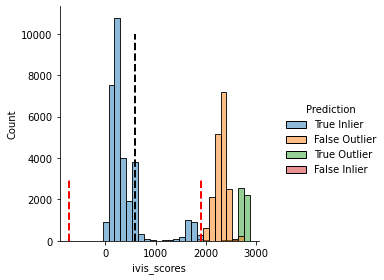

In [22]:
df["Label"] = df.outlier_label.map(lambda x: {-1.0:"outlier", 1.0:"inlier"}[x])
sns.displot(data=df,x="ivis_scores", hue="Prediction", palette="tab10", height=4, bins=25)
plt.plot([-726.75, -726.75], [0, 3000], color="red", linestyle='dashed', linewidth=2)
plt.plot([1904.28, 1904.28], [0, 3000], color="red", linestyle='dashed', linewidth=2)
plt.plot([589, 589], [0, 10000], color="black", linestyle='dashed', linewidth=2)
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/hist-wiki-ivis.svg", format="svg")

In [13]:
sr = scores
pcnt = (1 - 0.9) / 2
qlow, median, qhigh = np.quantile(sr, [pcnt, 0.50, 1-pcnt])
print(qlow, median, qhigh)
iqr = qhigh - qlow
print(iqr)
# x - median >= iqr/2
# x - 650 >= 505
print(median+iqr/2, median-iqr/2)

114.01459693908691 589.0259704589844 2744.2834594726564
2630.2688625335695
1904.1604017257691 -726.1084608078004


In [13]:
vecs_2d = umap_2d.fit_transform(docvecs)

In [20]:
contamination = 0.1
preds = reject_outliers(scores, iq_range=1.0-contamination)
df["pred"] = preds
df["Prediction"] = df.pred + df.outlier_label
df = df.replace({"Prediction":{-1.0:"False Inlier",0.0:"True Outlier",1.0:"True Inlier",2.0:"False Outlier"}})

In [15]:
preds

array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

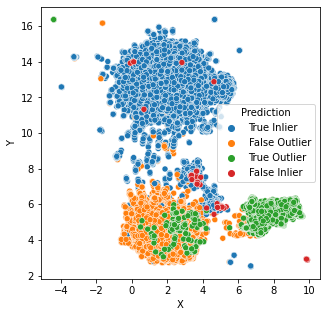

In [62]:
size = 5
plt.figure(figsize=(size,size))
df["X"] = vecs_2d[:, 0]
df["Y"] = vecs_2d[:, 1]
df["pred"] = preds
df["Prediction"] = df.pred + df.outlier_label
df = df.replace({"Prediction":{-1.0:"False Inlier",0.0:"True Outlier",1.0:"True Inlier",2.0:"False Outlier"}})
sns.scatterplot(data=df, x="X", y="Y", hue="Prediction", palette="tab10")
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-wiki-ivis.svg", format="svg")

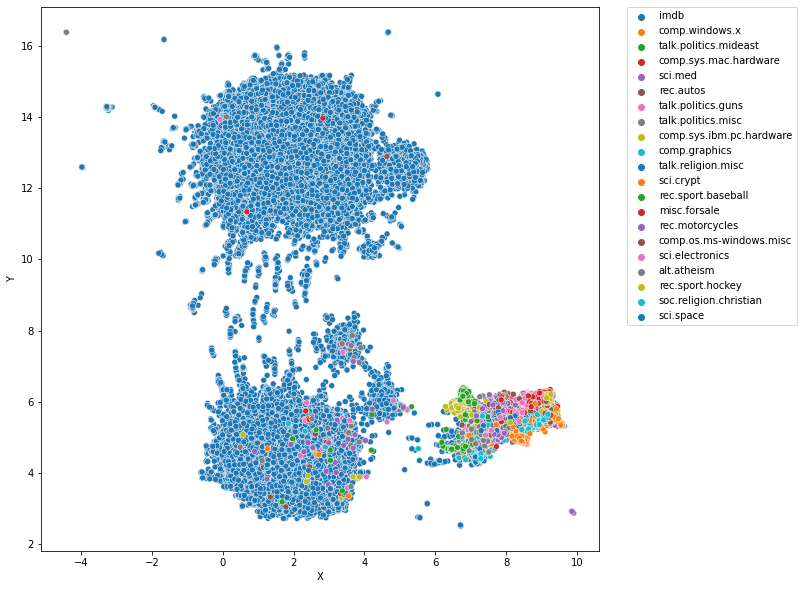

In [17]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="X", y="Y", hue="title", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-apnews-title.svg", format="svg")

## HDBSCAN

In [26]:
cluster_model = HDBSCAN(min_cluster_size=50)
cluster_pred = cluster_model.fit_predict(dim_reduced_vecs)

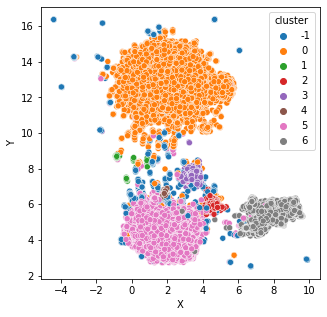

In [59]:
size = 5
plt.figure(figsize=(size,size))
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="cluster", palette="tab10")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-wiki-hdbscan.svg", format="svg")

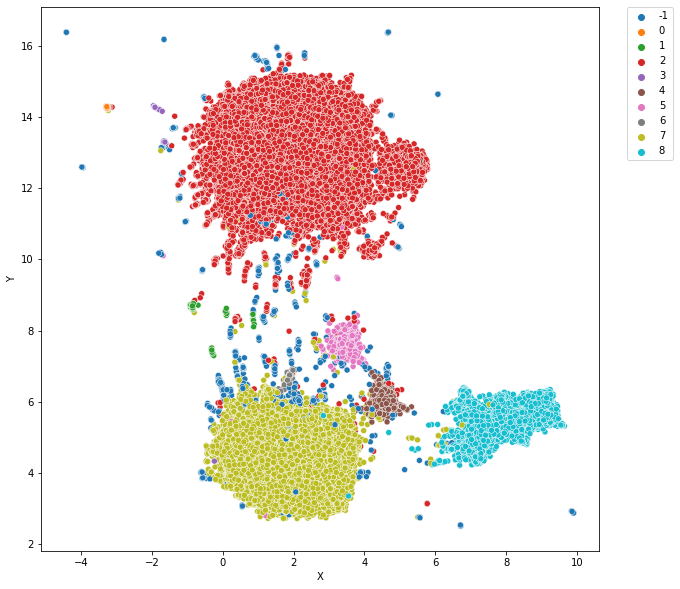

In [20]:
cluster_model = HDBSCAN(min_cluster_size=40)
cluster_pred = cluster_model.fit_predict(dim_reduced_vecs)

plt.figure(figsize=(10,10))
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="cluster", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

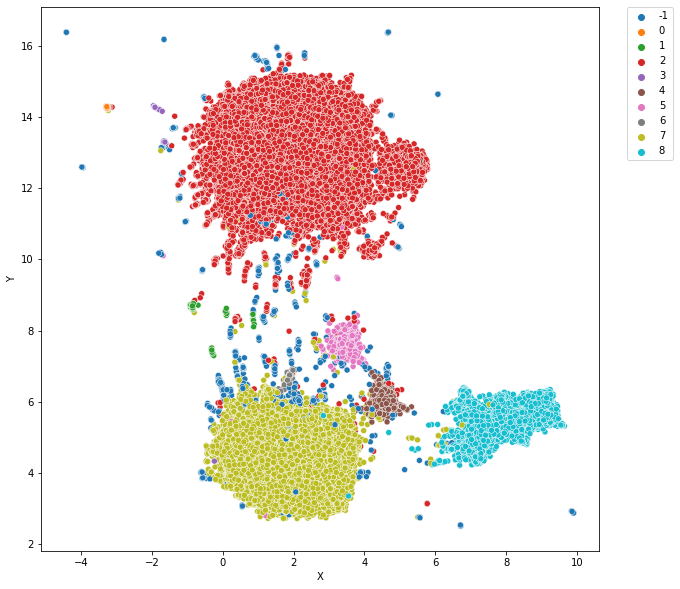

In [21]:
plt.figure(figsize=(10,10))
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="cluster", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-apnews-hdbscan.svg", format="svg")

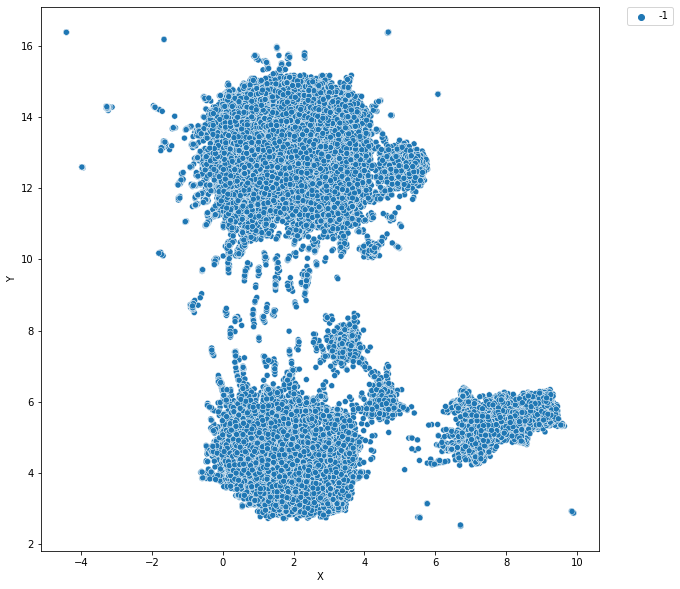

In [22]:
cluster_model = HDBSCAN(min_cluster_size=20)
cluster_pred = cluster_model.fit_predict(docvecs)

plt.figure(figsize=(10,10))
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="cluster", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [23]:
from sklearn.metrics import f1_score
a = reject_outliers(scores, iq_range=0.9)
a = [-1 if x else 1 for x in a]
f1_score(df.outlier_label, a, average='macro')

0.5640765109089116

In [55]:
bin_cluster = [-1 if x==6 else 1 for x in cluster_pred]
f1_score(df.outlier_label, bin_cluster, average='macro')

0.973204605127508

In [41]:
def decider(x):
    if x==6:
        return 1
    else:
        return 0
(df["cluster"].map(lambda x: decider(x)) + df.outlier_label).value_counts()

 1.0    49711
 0.0     4798
 2.0      289
-1.0      202
dtype: int64

In [52]:
def decider(x):
    if x==6:
        return -1
    else:
        return 1
df["cluster"].map(lambda x: decider(x)).value_counts()
df.outlier_label.value_counts()

 1.0    50000
-1.0     5000
Name: outlier_label, dtype: int64

## t-SNE

In [63]:
from sklearn.manifold import TSNE

tsnre_reduced = TSNE().fit_transform(docvecs)

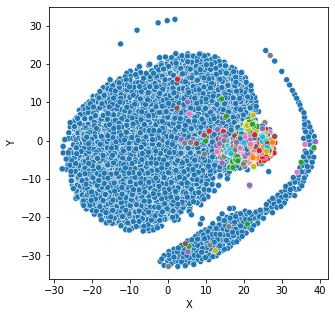

In [69]:
size = 5
plt.figure(figsize=(size,size))
df["Xt"] = tsnre_reduced[:, 0]
df["Yt"] = tsnre_reduced[:, 1]
sns.scatterplot(data=df, x="Xt", y="Yt", hue="title", palette="tab10")
plt.legend('',frameon=False)
plt.xlabel("X")
plt.ylabel("Y")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/wiki-tsne.svg", format="svg")

## k-Means

In [81]:
from sklearn.cluster import KMeans

kcluster_pred = KMeans(n_clusters=6).fit_predict(dim_reduced_vecs)

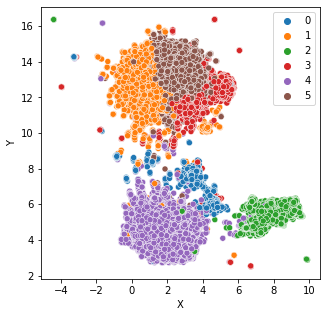

In [91]:
size = 5
plt.figure(figsize=(size,size))
df["kcluster"] = kcluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="kcluster", palette="tab10")
L=plt.legend()
L.get_texts()[0].set_text('0')
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-wiki-kmeans.svg", format="svg")

In [85]:
bin_cluster = [-1 if x==2 else 1 for x in kcluster_pred]
f1_score(df.outlier_label, bin_cluster, average='macro')

0.9758876693842349

In [92]:
kcluster_pred = KMeans(n_clusters=6).fit_predict(docvecs)

In [ ]:
size = 5
plt.figure(figsize=(size,size))
df["kcluster_nored"] = kcluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="kcluster_nored", palette="tab10")
L=plt.legend()
L.get_texts()[0].set_text('0')
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-wiki-kmeans_nored.svg", format="svg")

In [94]:
bin_cluster = [-1 if x==2 else 1 for x in kcluster_pred]
f1_score(df.outlier_label, bin_cluster, average='macro')

0.40683541300432474